## MDR VAE
This notebook contains a standard VAE with KL constrained to a minimum value, proposed as __MDR__ (Minimum Desired Rate) in
[Effective Estimation of Deep Generative Language Models](https://arxiv.org/abs/1904.08194). Because Pytorch optimizers only minimize I've slightly modified the notation, but the math stays the same.

We minimize the negative ELBO constrained by the KL:

$$ \min_{\theta, \lambda}\mathcal{L}(\theta, \lambda | \mathcal{D}) = - \mathbb{E}_{\mathcal{D}(X)}\left[\mathbb{E}_{q(z|x;\lambda) }[\log p(x|z ; \theta)] - \text{KL}(q(z|x;\lambda) || p(z))\right]\\
\text{s.t.}\;\text{KL}(q(z|x;\lambda) || p(z)) \geq r$$

Which can be reformulated as dual problem:
$$\max_{\alpha \in \mathbb{R}+}\min_{\theta, \lambda}\mathcal{L}(\theta, \lambda | \mathcal{D}) + \alpha (\text{KL} - r)$$
The second part of this loss is handled by the Constraint module, and $\max_\alpha$ by the ConstraintOptimizer

In [1]:
import torch
import torch.nn.functional as F
from torch.distributions import Normal, Bernoulli, kl_divergence
from torch.nn.utils.clip_grad import clip_grad_norm_
import matplotlib.pyplot as plt
from constraint import Constraint, ConstraintOptimizer
plt.style.use('seaborn')

class VAE(torch.nn.Module):
    """
    A minimal VAE implementation where
    p(x|z) = Bern(f(z; \theta))
    q(z|x) = N(mu(x; \lambda), softplus(std(x; \lambda)))
    p(z) = N(0, 1)
    """
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        self.inf_net = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, latent_size*2))

        self.gen_net = torch.nn.Sequential(
            torch.nn.Linear(latent_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, input_size))
        
    def q_z(self, x):
        h = self.inf_net(x)
        mean, std = torch.split(h, h.size(-1)//2, -1)
        return Normal(mean, F.softplus(std))
    
    def p_z(self):
        return Normal(0, 1)
    
    def p_x(self, z):
        return Bernoulli(logits=self.gen_net(z))
        
    def forward(self, x):
        q_z = self.q_z(x)
        p_z = self.p_z()
        p_x = self.p_x(q_z.rsample())
        
        # calculate loss
        ll = p_x.log_prob(x).sum(-1)
        kl = kl_divergence(q_z, p_z).sum(-1)
        # Interpretable metric, average element-wise accuracy
        acc = (p_x.sample() == x).detach().float().mean()
        return ll, kl, acc

In [2]:
# Let's train the VAE solve a simple task: Reconstruct a bitstring of 10 bits. 
# While simple, without any modifications to the loss the posterior collapses.

batch_size = 128
x_size = 10
hidden_size = 16
latent_size = 2
num_steps = 30000

def make_batch(batch_size, x_size):
    """Returns a batch of random bitstrings"""
    return torch.randint(0, 2, [batch_size, x_size]).float()

In [3]:
# Train VAE with ELBO without any modifications.
torch.manual_seed(0)
model = VAE(x_size, hidden_size, latent_size)
opt = torch.optim.Adam(model.parameters(), lr=5e-3)

# Save some values for plotting
kl_list = []
ll_list = []

for i in range(1, num_steps+1):
    model.train()
    opt.zero_grad()
    
    # Forward pass
    bx = make_batch(batch_size, x_size)
    ll, kl, acc = model(bx)
    # Loss
    elbo = ll - kl
    loss = -elbo.mean()
    # Backward pass
    loss.backward()
    clip_grad_norm_(model.parameters(), 1, float('inf'))
    opt.step()
    
    ll_list.append(ll.detach().mean())
    kl_list.append(kl.detach().mean())
    
    if not i % 100:
        s = '{}/{}\tll {:.3f}\tkl {:.3f}\tacc {:.3f}'.format(i, num_steps, ll.detach().mean(), kl.detach().mean(), acc)
        print(s, end='\r', flush=True)

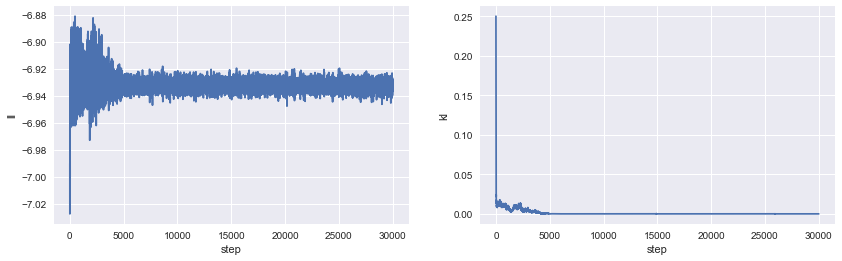

In [4]:
# A clear case of posterior collapse, KL goes to zero and the likelihood doesn't converge at all.

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(ll_list)), ll_list)
plt.xlabel('step')
plt.ylabel('ll')

plt.subplot(1, 2, 2)
plt.plot(range(len(kl_list)), kl_list)
plt.xlabel('step')
plt.ylabel('kl')
plt.show()

In [5]:
# Train the same VAE with ELBO, constrained by KL(q(z|x) || p(z)) >= 5
torch.manual_seed(0)
model = VAE(x_size, hidden_size, latent_size)
opt = torch.optim.Adam(model.parameters(), lr=5e-3)
# Define constraint
kl_constraint = Constraint(5, 'ge', alpha=0.5) # KL >= 5
# ConstraintOptimizer is a normal Optimizer, but step() does gradient ascent instead of descent.
constraint_opt = ConstraintOptimizer(
    torch.optim.RMSprop, kl_constraint.parameters(), 2e-3
)

# Save some values for plotting
kl_list = []
ll_list = []

for i in range(1, num_steps+1):
    model.train()
    opt.zero_grad()
    constraint_opt.zero_grad()
    
    # Forward pass
    bx = make_batch(batch_size, x_size)
    ll, kl, acc = model(bx)
    # Loss
    elbo = ll - kl
    loss = (-elbo + kl_constraint(kl)).mean()
    # Backward pass
    loss.backward()
    clip_grad_norm_(model.parameters(), 1, float('inf'))
    opt.step()
    constraint_opt.step()
    
    ll_list.append(ll.detach().mean())
    kl_list.append(kl.detach().mean())
    
    if not i % 100:
        s = '{}/{}\tll {:.3f}\tkl {:.3f}\tacc {:.3f}'.format(i, num_steps, ll.detach().mean(), kl.detach().mean(), acc)
        print(s, end='\r', flush=True)

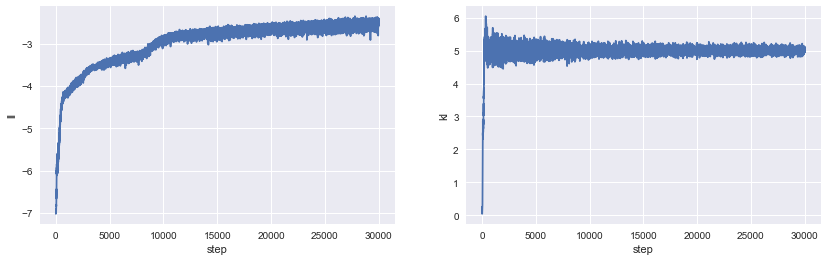

In [6]:
# With a constraint at KL >= 5 the model trains fine and achieves the target rate.
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(ll_list)), ll_list)
plt.xlabel('step')
plt.ylabel('ll')

plt.subplot(1, 2, 2)
plt.plot(range(len(kl_list)), kl_list)
plt.xlabel('step')
plt.ylabel('kl')
plt.show()